In [1]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)
from collections import Counter

from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from src.models.graphVAE import GraphVAE
from src.models.basicVae import LitBasicVae
from src.models.PointNetVae_chamfer_split import PointNetVAE
from torch.utils.data import Dataset, Subset
from torch_geometric.utils import to_dense_batch, to_dense_adj
import numpy as np
from src.utils.data_utils import *
from src.dataset_classes.graphDataset import *
from src.dataset_classes.sequenceDataset import *
from torch_geometric.loader import DataLoader as Pyg_DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
data = ProteinFamilyDataset(root='../data').to_point().torch()
graph_data = ProteinFamilyDataset(root='../data').to_graph(eps = 8).pyg()
seq_dataset = SequenceDataset(data, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size = 128, shuffle=False)

point_dataset = PointDataset(data, 500, return_proteins = True)
point_dataloader = DataLoader(point_dataset, batch_size = 128, shuffle=False)

### NEED TO USE PYG-DATALOADER ###
graph_dataset  = load_graph_data(graph_data, amnino_acids = 21)
graph_dataloader = Pyg_DataLoader(graph_dataset, batch_size=128, shuffle=False)

families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

# Count occurrences of each element
counter = Counter(families)

100%|██████████| 31109/31109 [00:06<00:00, 5001.66it/s]


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Run inference

In [4]:
seq_checkpoint_path = '../trained_models/Pfam/BVAE/BETA_EXP/0_LD16_HD512_Beta0.001_BetaInc0.ckpt' #'../trained_models/Pfam/BVAE/FINAL_MODEL/LD16_HD512_Beta0.005_BetaInc0.ckpt'
point_checkpoint_path = '../trained_models/Pfam/BETA_point_vae/Pfam_BETA_EXP/0_LD64_GF512_Beta0.001_HD512.ckpt' #"../trained_models/Pfam/PVAE/FINAL_MODEL/FINAL_PVAE_LD64_GF512_BetaInc0_Beta0.005_HD512_CH8.ckpt"
graph_checkpoint_path = '../trained_models/Pfam/GVAE/BETA_EXP/0_LD32_HD512_Beta0.001_GCH16_LR0.0001.ckpt'#'../trained_models/Pfam/GVAE/2_LD32_HD512_Beta0.005_GCH96_LR0.0001.ckpt'

seq_model = LitBasicVae.load_from_checkpoint(seq_checkpoint_path)
point_model = PointNetVAE.load_from_checkpoint(point_checkpoint_path)
graph_model = GraphVAE.load_from_checkpoint(graph_checkpoint_path)

# Put model in evaluation mode
seq_model.eval()
point_model.eval()
graph_model.eval()
graph_model.to(device)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.1, which is newer than your current Lightning version: v2.5.0.post0


GraphVAE(
  (conv1): GCNConv(21, 16)
  (conv2): GCNConv(16, 32)
  (fc_mu): Linear(in_features=16000, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=16000, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=512, bias=True)
  (fc2_dec_feature): Linear(in_features=512, out_features=10500, bias=True)
  (fc_adj_dec): Linear(in_features=32, out_features=16000, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (soft): Softmax(dim=-1)
)

In [ ]:
from tqdm import tqdm
original_seq_data = []
seq_res = [[],[],[]]
point_res = [[],[],[]]
graph_res = [[],[],[]]
sigma_coeff = [0, 0.5, 1]
# Run inference / decoding across different latent representations
for batch in tqdm(seq_dataloader):
    original_seq_data.append(batch)
    rep_z, x_mu, x_logvar, x_rec, logit = seq_model(batch.to(device))
    for i in sigma_coeff:
        cur_list = seq_res[i]
        latent_input = x_mu + i*torch.sqrt(torch.exp(x_logvar))
        decoded, _ = seq_model.decode(latent_input)
        cur_list.append(decoded.detach().cpu())
        seq_res[i] = cur_list

for batch in tqdm(point_dataloader):
    rep_z, x_mu, x_logvar, x_rec, logit = point_model(batch.to(device))
    for i in sigma_coeff:
        cur_list = point_res[i]
        latent_input = x_mu + i*torch.sqrt(torch.exp(x_logvar))
        decoded, _ = point_model.decode(latent_input)
        decoded = decoded[:,:, 3:]
        cur_list.append(decoded.detach().cpu())
        point_res[i] = cur_list

for batch in tqdm(graph_dataloader):
    rep_z, x_mu, x_logvar, x_rec, logit_feature, adj_matrix  = graph_model(batch.to(device))
    for i in sigma_coeff:
        cur_list = graph_res[i]
        latent_input = x_mu + i*torch.sqrt(torch.exp(x_logvar))
        decoded, _, _ = graph_model.decode(latent_input)
        cur_list.append(decoded.detach().cpu())
        graph_res[i] = cur_list

original_seq_data = torch.vstack(original_seq_data).argmax(dim=-1)

100%|██████████| 225/225 [00:34<00:00,  6.55it/s]


In [56]:
# Concatenate and do argmax to get predicted indices
for i in range(3):
    cur_seq = seq_res[i]
    cur_point = point_res[i]
    cur_graph = graph_res[i]

    seq_res[i] = torch.vstack(cur_seq).argmax(dim = -1)
    point_res[i] = torch.vstack(cur_point).argmax(dim = -1)
    graph_res[i] = torch.vstack(cur_graph).argmax(dim = -1)

In [57]:
# Convert to strings to BiPython
def convert_tensor_to_string(tens):
    amino_encoding_dict = {0: 'A',1: 'R',2: 'N',3: 'D',
                       4: 'C',5: 'E',6: 'Q',7: 'G',
                       8: 'H',9: 'I',10: 'L',11: 'K',
                       12: 'M',13: 'F',14: 'P',15: 'S',
                       16: 'T',17: 'W',18: 'Y', 19: 'V', 20: 'X'}
    
    out = []
    for sample in list(tens):
        string_sample = []
        for amino in list(sample):
            string_sample.append(amino_encoding_dict[amino.item()])
        out.append(''.join(string_sample))
    return out
        


amino_encoding_dict = {'A': 0,'R': 1,'N': 2,'D': 3,'C': 4,'E': 5,
                        'Q': 6,'G': 7,'H': 8,'I': 9,'L': 10,'K': 11,
                        'M': 12,'F': 13,'P': 14,'S': 15,'T': 16,
                        'W': 17,'Y': 18,'V': 19, 'X':20}

seq_string_res = [[],[],[]]
point_string_res = [[],[],[]]
graph_string_res = [[],[],[]]

for i in range(3):
    idx_string_res = convert_tensor_to_string(seq_res[i])
    seq_string_res[i] = idx_string_res

    idx_point_res = convert_tensor_to_string(point_res[i])
    point_string_res[i] = idx_point_res

    idx_graph_res = convert_tensor_to_string(graph_res[i])
    graph_string_res[i] = idx_graph_res

original_string_seq_data = convert_tensor_to_string(original_seq_data)

In [ ]:
from Bio import Align
from Bio.Align import substitution_matrices
matrix = substitution_matrices.load("BLOSUM62")
seq_comparison_results = [[],[],[]]
point_comparison_results = [[],[],[]]
graph_comparison_results = [[],[],[]]

aligner = Align.PairwiseAligner()
aligner.mode = 'local'
aligner.substitution_matrix = matrix
aligner.match_score = 1.0
aligner.mismatch_score = -2.0
aligner.gap_score = -2.5

# Compare original sequences to reconstructed, latent 1 and latent 2 using BioPython Library 
for i in range(3):
    total_seq_comp = []
    total_point_comp = []
    total_graph_comp = []

    for idx in range(len(original_string_seq_data)):
        og_end_idx = torch.where(original_seq_data[idx] == 20)[0].item()
        og_string = original_string_seq_data[idx][:og_end_idx]

        seq_end_idx = torch.where(seq_res[i][idx] == 20)[0][0].item()

        # If no end token is generated i.e 20 is not present then take the entire string
        try:
            point_end_idx = torch.where(point_res[i][idx] == 20)[0][0].item()
        except:
            point_end_idx = 499

        try:
            graph_end_idx = torch.where(graph_res[i][idx] == 20)[0][0].item()
        except:
            graph_end_idx = 499
            
        seq_string = seq_string_res[i][idx][:seq_end_idx]
        point_string = point_string_res[i][idx][:point_end_idx]
        graph_string = graph_string_res[i][idx][:graph_end_idx]
        seq_align_score = aligner.score(og_string, seq_string)
        point_align_score = aligner.score(og_string, point_string)
        graph_align_score = aligner.score(og_string, graph_string)

        total_seq_comp.append(seq_align_score)
        total_point_comp.append(point_align_score)
        total_graph_comp.append(graph_align_score)
    
    seq_comparison_results[i] = total_seq_comp
    point_comparison_results[i] = total_point_comp
    graph_comparison_results[i] = total_graph_comp

In [65]:
seq_averages = [0]*3
point_averages = [0]*3
graph_averages = [0]*3

for i in range(3):
    seq_averages[i] = sum(seq_comparison_results[i]) / len(seq_comparison_results[i])
    point_averages[i] = sum(point_comparison_results[i]) / len(point_comparison_results[i])
    graph_averages[i] = sum(graph_comparison_results[i]) / len(graph_comparison_results[i])

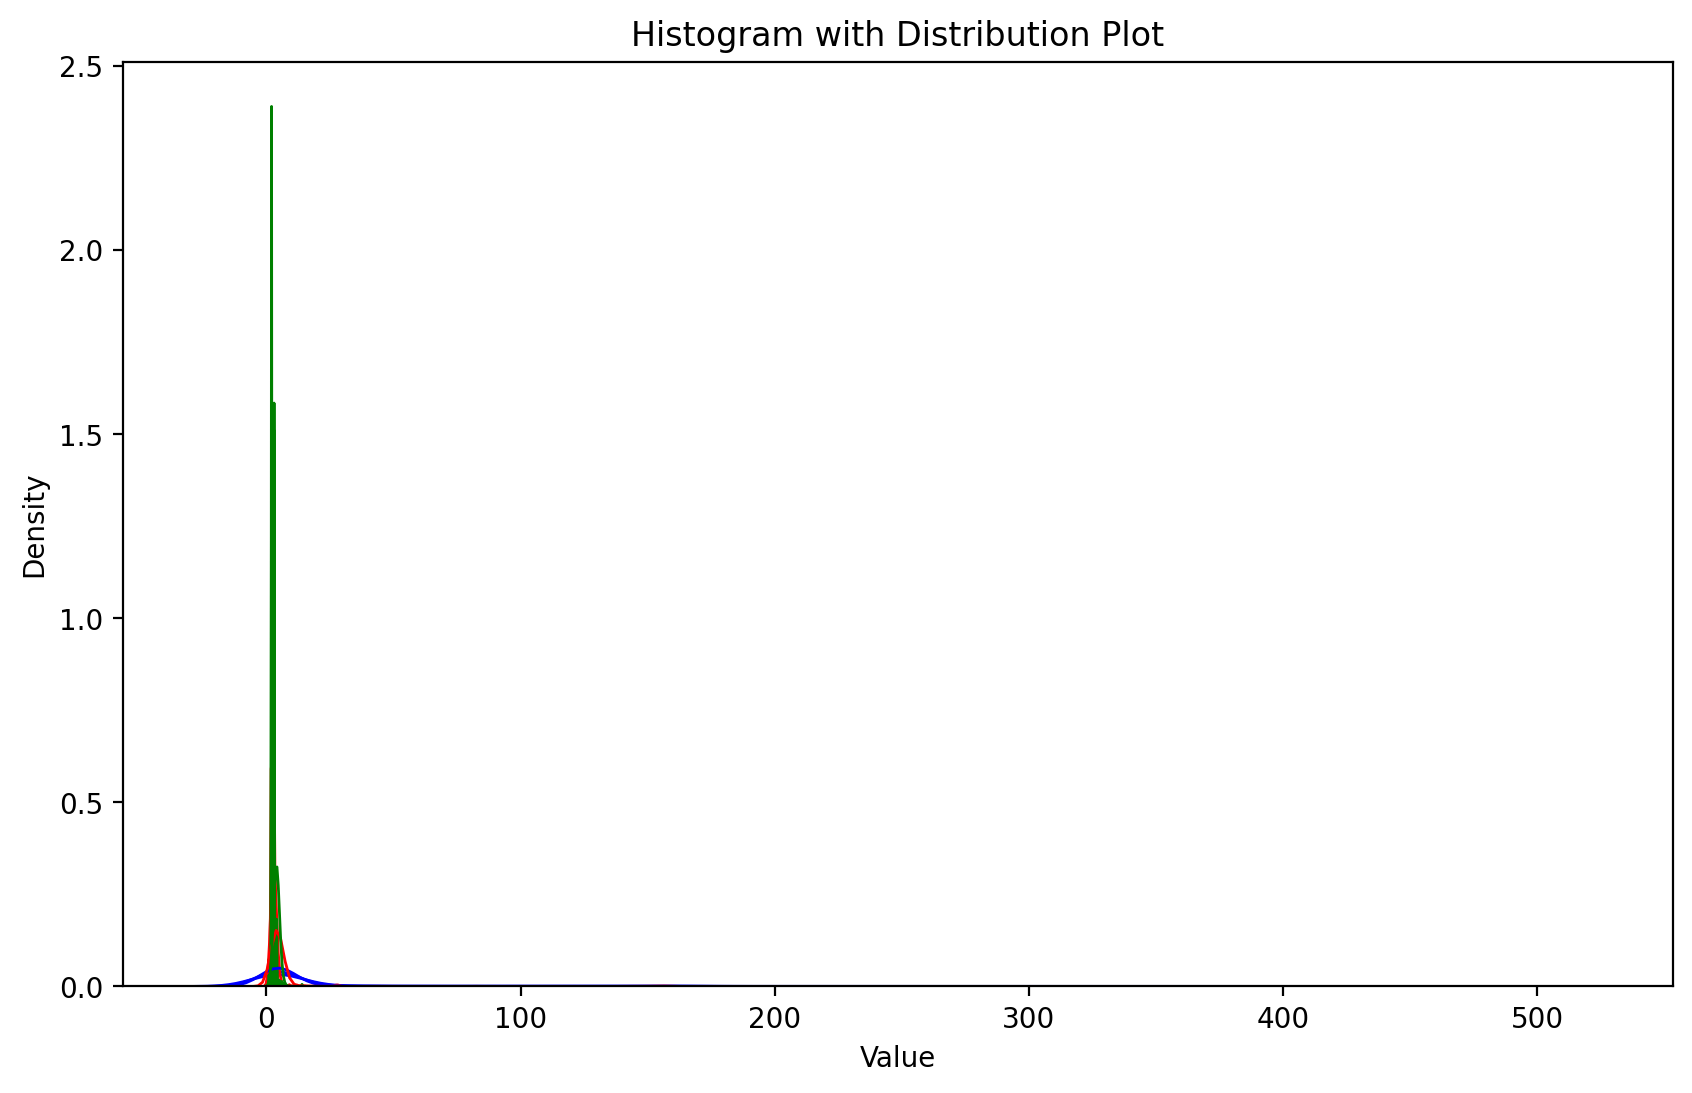

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate random data (e.g., 1000 points from a normal distribution)
data = seq_comparison_results

# Set up the figure and axes
plt.figure(figsize=(10, 6), dpi = 200)

# Plot histogram using seaborn (with KDE)
sns.kdeplot(seq_comparison_results[0],color='b', linewidth=1)
sns.kdeplot(seq_comparison_results[1],color='r',  linewidth=1)
sns.kdeplot(seq_comparison_results[2], color='g',  linewidth=1)

sns.kdeplot(point_comparison_results[0],color='b', linewidth=1)
sns.kdeplot(point_comparison_results[1],color='r',  linewidth=1)
sns.kdeplot(point_comparison_results[2], color='g',  linewidth=1)

sns.kdeplot(graph_comparison_results[0],color='b', linewidth=1)
sns.kdeplot(graph_comparison_results[1],color='r',  linewidth=1)
sns.kdeplot(graph_comparison_results[2], color='g',  linewidth=1)

# Add titles and labels
plt.title('Histogram with Distribution Plot')
# plt.xlim(-10,20)
plt.xlabel('Value')
plt.ylabel('Density')

# Show the plot
plt.show()


In [74]:
import statistics

for i in range(3):
    print(f'{i} : {statistics.median(seq_comparison_results[i])}')
    print(f'{i} : {statistics.median(point_comparison_results[i])}')
    print(f'{i} : {statistics.median(graph_comparison_results[i])}')

0 : 4.0
0 : 4.0
0 : 4.0
1 : 3.0
1 : 3.0
1 : 4.0
2 : 2.0
2 : 3.0
2 : 4.0
